✅ Successfully loaded the performance dataset.
Found player with the most seasons of data: James Philip Milner

--- Generated Performance Time-Series for James Philip Milner ---
      season  totalGoals  goalAssists  totalShots
6938   15/16         5.0         11.0        35.0
7652   16/17         7.0          3.0        36.0
8470   17/18         0.0          3.0        21.0
9116   18/19         5.0          4.0        24.0
9586   19/20         2.0          2.0        12.0
10266  20/21         0.0          1.0         8.0

Building and training the final LSTM model to predict future goals...


c:\Users\SUBBU\Downloads\TransferIQ-Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 50)          │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1404
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1238 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1148 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1059 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0975 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0962 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0883 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0874 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0839 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0827 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0819 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0832 
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0809 
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0807 
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0795 
Epoch 16/100
4/4 ━━━

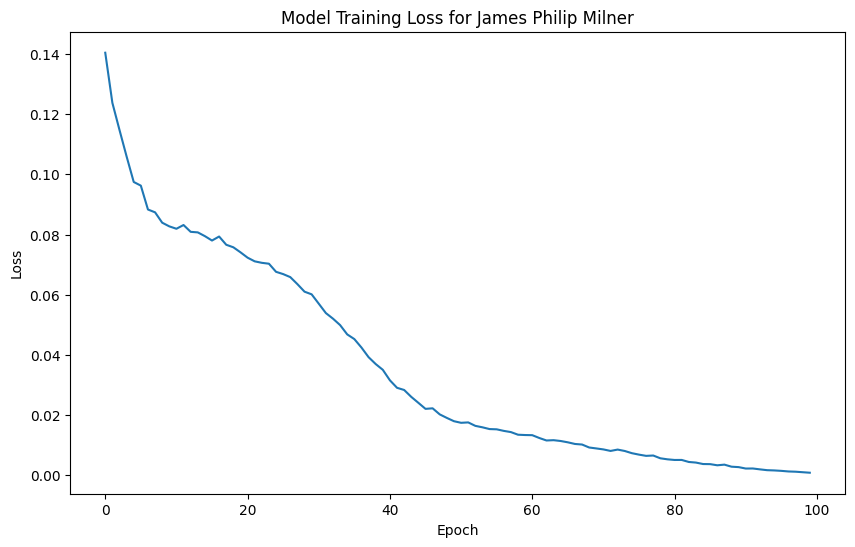


✅ Final model training complete! We have successfully built a time-series model to predict future performance.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- 1. Load the Performance Dataset ---
try:
    df_perf = pd.read_csv('Full Dataset (league standings with players stats).csv')
    print("✅ Successfully loaded the performance dataset.")
except FileNotFoundError:
    print("❌ File not found. Make sure 'Full Dataset...' is in your project folder.")
    exit()

# --- 2. Clean Data and Find the Best Player ---
# Drop messy columns and create a full name
df_perf = df_perf.loc[:, ~df_perf.columns.str.contains('^Unnamed')]
df_perf['fullname'] = df_perf['firstname'] + ' ' + df_perf['lastname']

# Find the player with the most seasons of data
player_season_counts = df_perf['fullname'].value_counts()
player_name = player_season_counts.index[0]
print(f"Found player with the most seasons of data: {player_name}")

# --- 3. Create the Time-Series for That Player ---
df_player = df_perf[df_perf['fullname'] == player_name].copy()
# Sort by season to create a proper timeline
df_player = df_player.sort_values('season').dropna(subset=['totalGoals', 'goalAssists', 'totalShots'])

print(f"\n--- Generated Performance Time-Series for {player_name} ---")
print(df_player[['season', 'totalGoals', 'goalAssists', 'totalShots']])

# --- 4. Prepare Data for LSTM Model ---
# Features: Goals, Assists, Shots. Target: Next Season's Goals.
features = ['totalGoals', 'goalAssists', 'totalShots']
data_to_train = df_player[features].copy()
sequence_length = 2 # Use past 2 seasons to predict the next

if len(data_to_train) <= sequence_length:
    print(f"❌ Error: Dataset for {player_name} is too small ({len(data_to_train)} points).")
else:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_to_train)
    
    X_train, y_train = [], []
    for i in range(sequence_length, len(scaled_data)):
        X_train.append(scaled_data[i-sequence_length:i, :]) # Input: Past seasons' stats
        y_train.append(scaled_data[i, 0]) # Target: Current season's goals (the first feature)

    X_train, y_train = np.array(X_train), np.array(y_train)

    # --- 5. Build and Train the Final Model ---
    print("\nBuilding and training the final LSTM model to predict future goals...")
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=50),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

    # --- 6. Plot Training Loss ---
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.title(f'Model Training Loss for {player_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    print("\n✅ Final model training complete! We have successfully built a time-series model to predict future performance.")

In [6]:
# --- 7. Make a Prediction on the Last Sequence ---
# Get the last sequence from our training data
last_sequence = X_train[-1]

# Reshape it to make a single prediction
last_sequence = np.reshape(last_sequence, (1, last_sequence.shape[0], last_sequence.shape[1]))

# Get the model's prediction (which will be a scaled value)
scaled_prediction = model.predict(last_sequence)

# To understand the prediction, we need to reverse the scaling
# We need to create a dummy array with the same shape as our original data
# and place our prediction in the 'goals' column (the first column)
prediction_dummy = np.zeros(shape=(1, data_to_train.shape[1]))
prediction_dummy[0, 0] = scaled_prediction[0][0]



# Now, inverse transform the dummy array
unscaled_prediction = scaler.inverse_transform(prediction_dummy)

predicted_goals = unscaled_prediction[0, 0]

print("\n--- Model Prediction ---")
print(f"Based on the last {sequence_length} seasons, the model predicts {predicted_goals:.2f} goals for the next season.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

--- Model Prediction ---
Based on the last 2 seasons, the model predicts 0.33 goals for the next season.


In [3]:
import pandas as pd

# Load the performance data
df_perf = pd.read_csv('Full Dataset (league standings with players stats).csv')

# Create the full name column
df_perf['fullname'] = df_perf['firstname'] + ' ' + df_perf['lastname']

# Search for the player and print their exact name
mbappe_data = df_perf[df_perf['fullname'].str.contains("Mbappe", case=False, na=False)]
print("Found the following matching names:")
print(mbappe_data['fullname'].unique())

Found the following matching names:
[]
